<a href="https://colab.research.google.com/github/hydrationn/Machine-DeepLearning/blob/main/DeepLearning/assignment/%EA%B3%BC%EC%A0%9C05_1_Sequence_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model 1: RNN

In [ ]:
# Import package

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
# GPU/CPU setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

cpu


In [ ]:
# import dataset

import yfinance as yf

aapl = yf.download('AAPL', start='2019-01-01', end='2023-12-31')
googl = yf.download('GOOGL', start='2019-01-01', end='2023-12-31')
aapl
googl

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,51.360001,53.039501,51.264000,52.734001,52.734001,31868000
2019-01-03,52.533501,53.313000,51.118500,51.273499,51.273499,41960000
2019-01-04,52.127998,54.000000,51.842999,53.903500,53.903500,46022000
2019-01-07,54.048500,54.134998,53.132000,53.796001,53.796001,47446000
2019-01-08,54.299999,54.667500,53.417500,54.268501,54.268501,35414000
...,...,...,...,...,...,...
2023-12-22,140.770004,141.990005,140.710007,141.490005,141.490005,26514600
2023-12-26,141.589996,142.679993,141.190002,141.520004,141.520004,16780300
2023-12-27,141.589996,142.080002,139.889999,140.369995,140.369995,19628600


In [ ]:
# Data preprocessing

from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data):
    df = pd.DataFrame(data['Close'])
    data_values = df.values.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_values)
    return scaled_data, scaler

data_aapl, scaler_aapl = preprocess_data(aapl)
data_googl, scaler_googl = preprocess_data(googl)

train_ratio = 0.8
split_aapl = int(train_ratio * len(data_aapl))
split_googl = int(train_ratio * len(data_googl))

aapl_train = data_aapl[:split_aapl, :]
aapl_test = data_aapl[split_aapl:, :]
googl_train = data_googl[:split_googl, :]
googl_test = data_googl[split_googl:, :]

In [ ]:
# Create sequences

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train_aapl, y_train_aapl = create_sequences(aapl_train, sequence_length)
x_test_aapl, y_test_aapl = create_sequences(aapl_test, sequence_length)
x_train_googl, y_train_googl = create_sequences(googl_train, sequence_length)
x_test_googl, y_test_googl = create_sequences(googl_test, sequence_length)

In [ ]:
# Convert to PyTorch tensors

x_train_aapl, y_train_aapl = torch.tensor(x_train_aapl).float(), torch.tensor(y_train_aapl).float()
x_test_aapl, y_test_aapl = torch.tensor(x_test_aapl).float(), torch.tensor(y_test_aapl).float()
x_train_googl, y_train_googl = torch.tensor(x_train_googl).float(), torch.tensor(y_train_googl).float()
x_test_googl, y_test_googl = torch.tensor(x_test_googl).float(), torch.tensor(y_test_googl).float()

In [ ]:
# Batch generation

batch_size = 20
train_loader_aapl = DataLoader(list(zip(x_train_aapl, y_train_aapl)), batch_size=batch_size, shuffle=True)
test_loader_aapl = DataLoader(list(zip(x_test_aapl, y_test_aapl)), batch_size=batch_size, shuffle=False)
train_loader_googl = DataLoader(list(zip(x_train_googl, y_train_googl)), batch_size=batch_size, shuffle=True)
test_loader_googl = DataLoader(list(zip(x_test_googl, y_test_googl)), batch_size=batch_size, shuffle=False)

In [ ]:
# Model

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.device = device
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [ ]:
# Hyperparameters

input_size = 1
output_size = 1
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 100

model_aapl = RNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_aapl.parameters(), lr=learning_rate)

In [ ]:
# Train

losses_aapl = []
for epoch in range(num_epochs):
    model_aapl.train()
    epoch_losses = []
    for inputs, targets in train_loader_aapl:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_aapl(inputs.unsqueeze(-1))
        loss = criterion(outputs. squeeze(-1), targets)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    losses_aapl.append(np.mean(epoch_losses))
    print(f'Epoch {epoch+1}/{num_epochs}, AAPL Train Loss: {np.mean(epoch_losses):.6f}')

Epoch 1/100, AAPL Train Loss: 0.036139
Epoch 2/100, AAPL Train Loss: 0.001112
Epoch 3/100, AAPL Train Loss: 0.000913
Epoch 4/100, AAPL Train Loss: 0.000906
Epoch 5/100, AAPL Train Loss: 0.000945
Epoch 6/100, AAPL Train Loss: 0.000914
Epoch 7/100, AAPL Train Loss: 0.000884
Epoch 8/100, AAPL Train Loss: 0.000793
Epoch 9/100, AAPL Train Loss: 0.000842
Epoch 10/100, AAPL Train Loss: 0.000736
Epoch 11/100, AAPL Train Loss: 0.000678
Epoch 12/100, AAPL Train Loss: 0.000855
Epoch 13/100, AAPL Train Loss: 0.000753
Epoch 14/100, AAPL Train Loss: 0.000677
Epoch 15/100, AAPL Train Loss: 0.000654
Epoch 16/100, AAPL Train Loss: 0.000614
Epoch 17/100, AAPL Train Loss: 0.000508
Epoch 18/100, AAPL Train Loss: 0.000521
Epoch 19/100, AAPL Train Loss: 0.000470
Epoch 20/100, AAPL Train Loss: 0.000522
Epoch 21/100, AAPL Train Loss: 0.000627
Epoch 22/100, AAPL Train Loss: 0.000434
Epoch 23/100, AAPL Train Loss: 0.000413
Epoch 24/100, AAPL Train Loss: 0.000557
Epoch 25/100, AAPL Train Loss: 0.000427
Epoch 26/

In [ ]:
# Validation

model_aapl.eval()
train_pred = model_aapl(x_train_aapl.unsqueeze(-1).to(device)).squeeze().detach().cpu().numpy()
test_pred = model_aapl(x_test_aapl.unsqueeze(-1).to(device)).squeeze().detach().cpu().numpy()

val_losses_aapl = []

with torch.no_grad():
    for inputs, targets in test_loader_aapl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_aapl(inputs.unsqueeze(-1))
        val_loss = criterion(outputs.squeeze(-1), targets)
        val_losses_aapl.append(val_loss.item())
print(f'AAPL Validation Loss: {np.mean(val_losses_aapl):.6f}')

AAPL Validation Loss: 0.000278


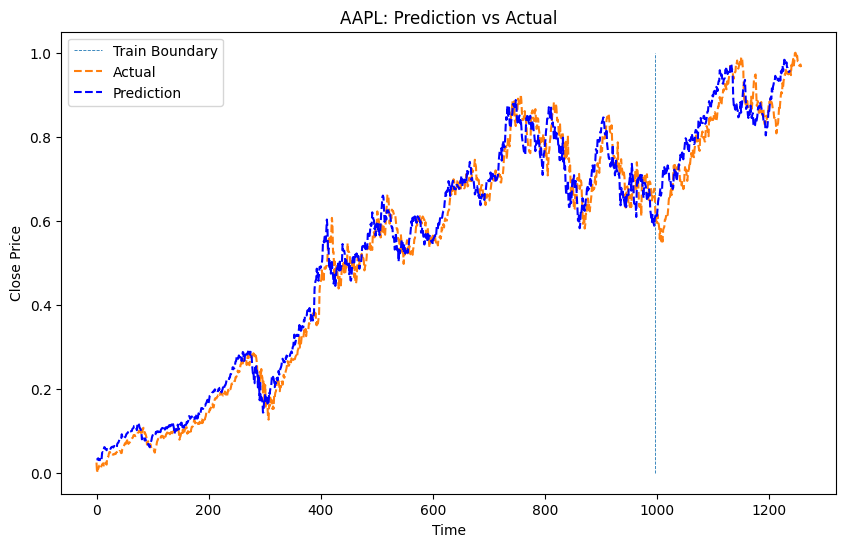

In [ ]:
# Plot

total_pred = np.concatenate([train_pred, test_pred])

plt.figure(figsize=(10, 6))
plt.plot(np.ones(100) * len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total_pred, 'b--')
plt.legend(['Train Boundary', 'Actual', 'Prediction'])
plt.title('AAPL: Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()